# Churn Prediction Model

Este notebook entrena un modelo de machine learning para predecir churn usando las features generadas por dbt.


In [1]:
import pandas as pd
import numpy as np
import duckdb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Conectar a la base de datos
conn = duckdb.connect('churn_prediction.duckdb')

# Cargar features desde dbt
# Nota: DuckDB crea esquemas con prefijo 'main_', por lo que usamos 'main_marts'
df = conn.execute("SELECT * FROM main_marts.fct_churn_features").df()
print(f"Shape: {df.shape}")
print(f"Churn rate: {df['is_churned'].mean():.2%}")


Shape: (10000, 72)
Churn rate: 14.16%


In [3]:
# Seleccionar features (excluir IDs, fechas, target y columnas categóricas)
exclude_cols = [
    'user_id', 'email', 'is_churned', 'days_to_churn', 
    'signup_date', 'first_event_date', 'last_event_date', 
    'first_payment_date', 'last_payment_date', 
    'first_ticket_date', 'last_ticket_date', 
    'feature_generated_at', 'status', 'country', 'plan_type'
]

# Obtener solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

X = df[feature_cols].fillna(0)
y = df['is_churned']

print(f"Features numéricas seleccionadas: {len(feature_cols)}")
print(f"Samples: {len(X)}")
print(f"\nPrimeras 10 features: {feature_cols[:10]}")


Features numéricas seleccionadas: 57
Samples: 10000

Primeras 10 features: ['days_since_signup', 'months_since_signup', 'signup_month', 'signup_quarter', 'signup_day_of_week', 'total_events', 'active_days', 'unique_event_types', 'login_count', 'view_count']


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Métricas
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

       False       0.92      1.00      0.96      1717
        True       1.00      0.48      0.65       283

    accuracy                           0.93      2000
   macro avg       0.96      0.74      0.81      2000
weighted avg       0.93      0.93      0.92      2000


ROC-AUC Score: 0.8804


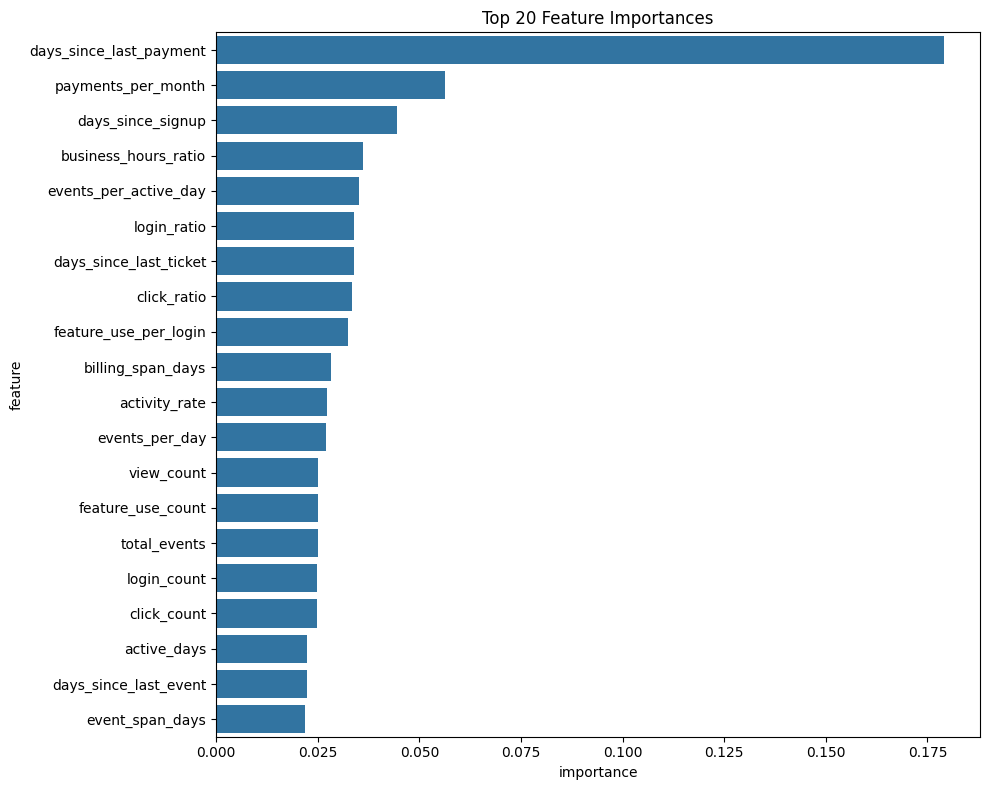

In [5]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()


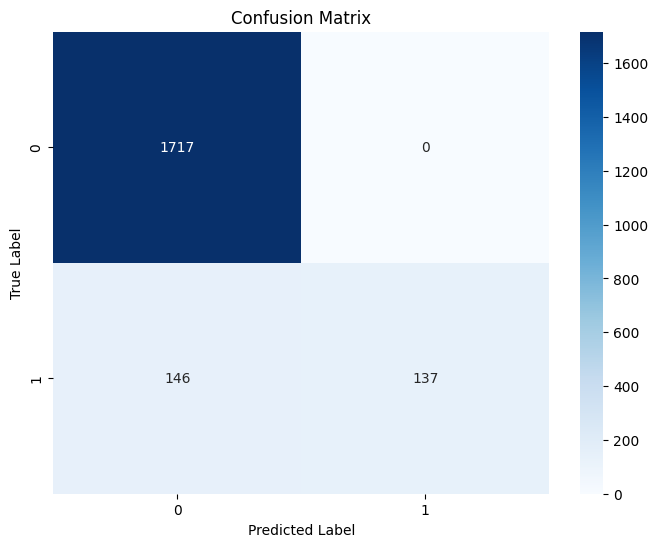

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
